# Object Detection using TorchVision and Albumentations

## Custom Dataset

In [1]:
from typing import Any
from pathlib import Path
from collections.abc import Callable, Iterable
import random

from matplotlib import pyplot as plt

import numpy as np
import torch
import cv2

In [378]:
from collections import defaultdict
import json

StrOrPath = str | Path

class CustomCOCODataset(torch.utils.data.Dataset):
    def __init__(self, annotation_path: StrOrPath, image_root: StrOrPath, transform: Callable[..., dict[str, Any]] | None = None):
        self.image_root = Path(image_root)
        self.image_metadata_list, self.category_idx2name = self.process_json(annotation_path)
        self.transform = transform


    @staticmethod
    def process_json(json_path: StrOrPath):
        with open(json_path) as f:
            data = json.load(f)

        annotations: list[dict[str, Any]] = data["annotations"]
        images: list[dict[str, Any]] = data["images"]

        img_id2anno: dict[int, Any] = defaultdict(list)

        for anno in annotations:
            image_id = anno.pop("image_id")
            img_id2anno[image_id].append(anno)

        for img in images:
            img["annotations"] = img_id2anno.get(img["id"], [])

        category_idx2name: dict[int, str] = {cat["id"]: cat["name"] for cat in data["categories"]}

        return images, category_idx2name


    def __getitem__(self, idx: int):
        image_metadata = self.image_metadata_list[idx]

        image_filename = image_metadata["file_name"]

        img_path = self.image_root / image_filename

        image = cv2.imread(str(img_path), cv2.IMREAD_COLOR)

        if image is None:
            msg = f"Image not found in the path: {img_path}"
            raise ValueError(msg)

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        annotations = image_metadata["annotations"]

        # convert everything into a torch.Tensor
        bboxes = [anno["bbox"] for anno in annotations]

        labels = torch.as_tensor([anno["category_id"] for anno in annotations], dtype=torch.int64)
        
        class_labels = [self.category_idx2name[anno["category_id"]] for anno in annotations]

        image_id = image_metadata["id"]

        # suppose all instances are not crowd
        # iscrowd = [anno["iscrowd"] for anno in annotations]
        # iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)


        kwargs = {"image": image, "bboxes": bboxes, "class_labels": class_labels, "labels": labels, "image_id": image_id}
        
        if self.transform is not None:
            kwargs = self.transform(**kwargs)

        newbbox = []
        for bbox in kwargs["bboxes"]:
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            newbbox.append([x_min, y_min, x_max, y_max])

        del kwargs["bboxes"]
        
        kwargs["boxes"] = torch.tensor(newbbox, dtype=torch.float32).view(-1, 4)

        image = kwargs.pop("image")

        return image, kwargs

    def __len__(self):
        return len(self.image_metadata_list)

In [379]:
ROOT_DIR = Path("/home/maverick/Downloads/Tree Detection.v5i.coco/train/")

In [380]:
ds = CustomCOCODataset(
    annotation_path = ROOT_DIR / "_annotations.coco.json",
    image_root = ROOT_DIR
)

## Get image intensities

In [6]:
intensities = np.vstack([data["image"].reshape(-1, 3) for data in ds]) / 255

In [7]:
intensities.shape

(180633600, 3)

In [7]:
intensities.mean(0) # array([0.384438  , 0.51055843, 0.46215833])

array([0.384438  , 0.51055843, 0.46215833])

In [8]:
intensities.std(0, ddof=1) # array([0.30889839, 0.29740697, 0.29249325])

array([0.30889839, 0.29740697, 0.29249325])

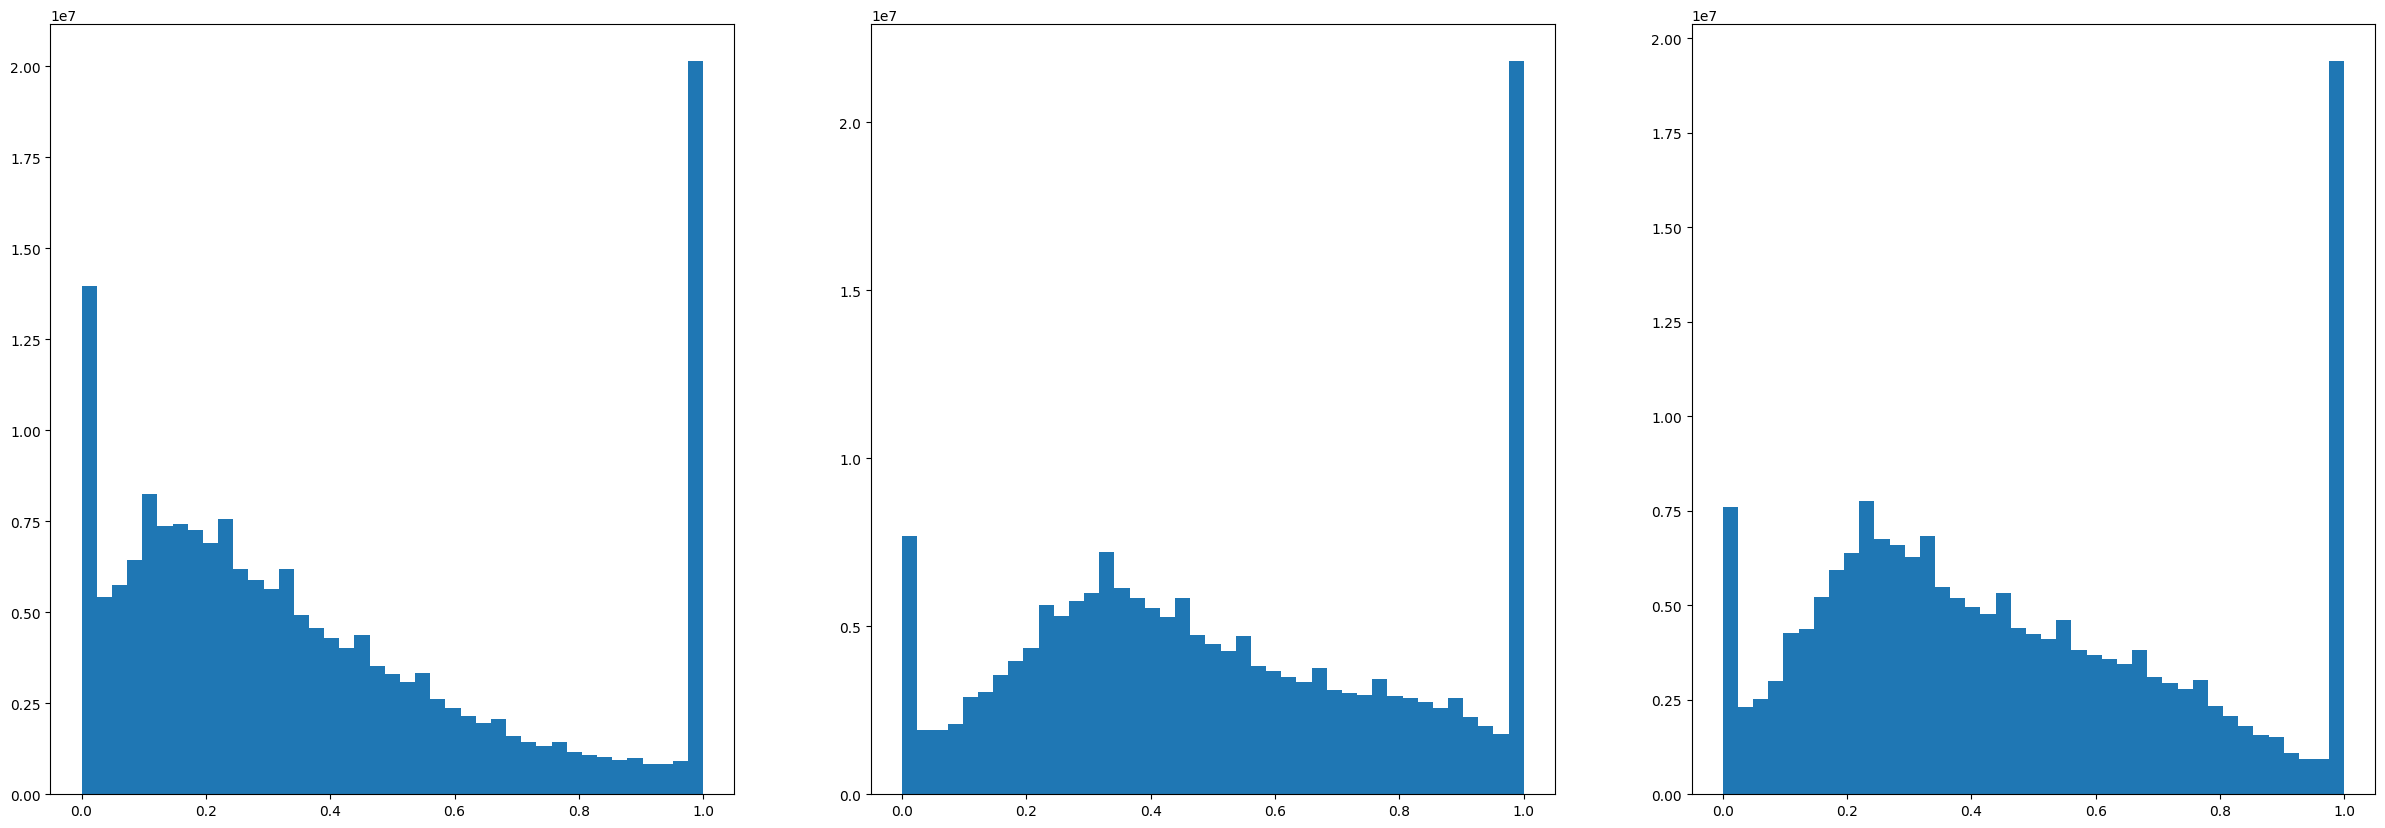

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

# From "doane": 41
bins = 41

ax1.hist(intensities[:, 0], bins=bins)
ax1.set_title("Red")

ax2.hist(intensities[:, 1], bins=bins)
ax1.set_title("Green")

ax3.hist(intensities[:, 2], bins=bins)
ax1.set_title("Blue");

## Plot images and transforms

In [99]:
first = ds[151]
first

{'image_id': 151,
 'image': array([[[ 51, 102,  85],
         [ 51, 102,  85],
         [ 51, 102,  85],
         ...,
         [ 79, 132, 126],
         [ 75, 128, 122],
         [ 72, 125, 119]],
 
        [[ 51, 102,  85],
         [ 51, 102,  85],
         [ 51, 102,  85],
         ...,
         [ 79, 132, 126],
         [ 75, 128, 122],
         [ 72, 125, 119]],
 
        [[ 51, 102,  85],
         [ 51, 102,  85],
         [ 51, 102,  85],
         ...,
         [ 78, 131, 123],
         [ 75, 128, 120],
         [ 72, 125, 117]],
 
        ...,
 
        [[ 24,  65,  67],
         [ 24,  65,  67],
         [ 25,  64,  69],
         ...,
         [100, 135, 102],
         [101, 135, 102],
         [100, 134, 101]],
 
        [[ 24,  65,  67],
         [ 24,  65,  67],
         [ 25,  65,  67],
         ...,
         [101, 135, 102],
         [103, 134, 102],
         [102, 133, 101]],
 
        [[ 23,  64,  66],
         [ 23,  64,  66],
         [ 25,  65,  67],
         ...,
 

In [100]:
colors = {"simal": (255, 0, 0), "sissoo": (255, 255, 0)}

def plot(image: np.ndarray, bboxes: list[list], class_labels: list[str], axis=plt, *args, **kwargs):
    new_image = image.copy()
    for bbox, label in zip(bboxes, class_labels):
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        cv2.rectangle(new_image,(round(x_min), round(y_min)), (round(x_max), round(y_max)), colors[label], 2)
    axis.imshow(new_image)

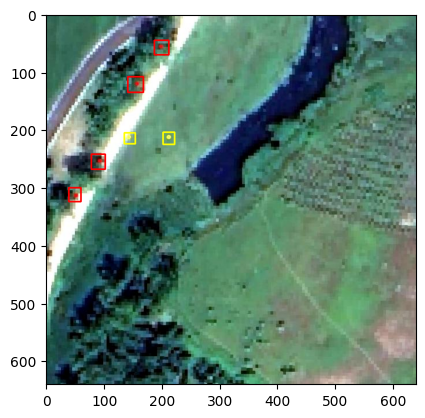

In [101]:
plot(**first)

In [102]:
import albumentations as A

In [103]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomScale(scale_limit=0.2, interpolation=cv2.INTER_CUBIC, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
    A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255), interpolation=cv2.INTER_CUBIC, rotate_method="ellipse", p=0.2),
    A.RandomSizedBBoxSafeCrop(640, 640, interpolation=cv2.INTER_CUBIC)
], bbox_params=A.BboxParams(format="coco", label_fields=["class_labels"], min_visibility=0.1))

In [104]:
# transformed = transform(**first)

In [105]:
# transformed

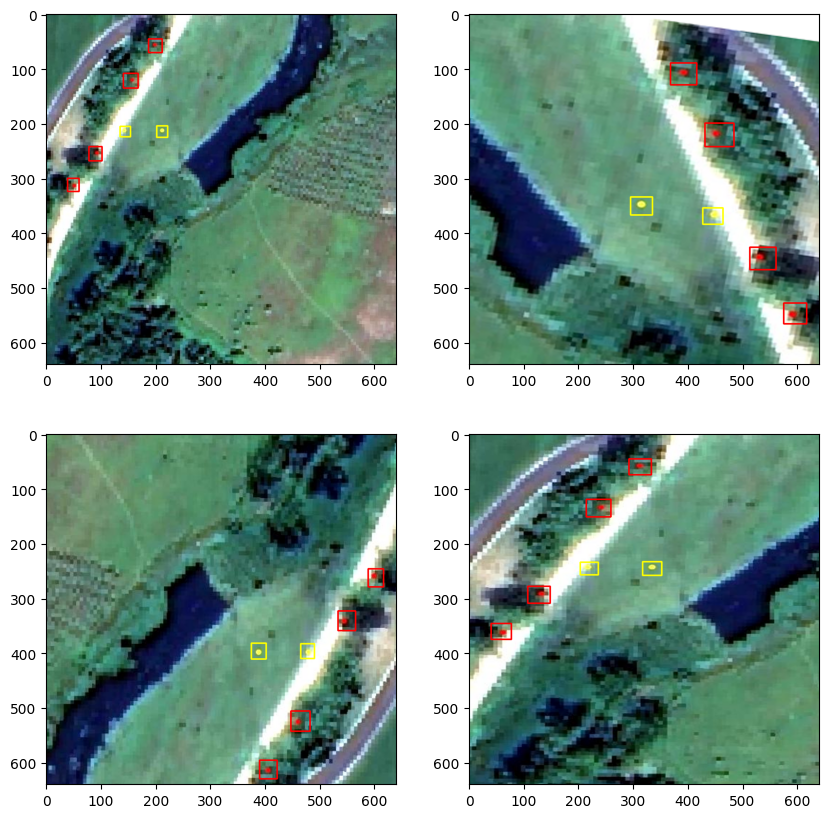

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

(ax1, ax2, ax3, ax4) = axes.flatten()

plot(**first, axis=ax1)
plot(**transform(**first), axis=ax2)
plot(**transform(**first), axis=ax3)
plot(**transform(**first), axis=ax4)

## Model

In [107]:
import torch

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

/home/maverick/Projects/ml-scratchpad/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [108]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 3  # 2 classes (sissoo and simal) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [109]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

## Check Model and Dataset

In [381]:
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
    A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255), rotate_method="ellipse", p=0.2),
    A.RandomSizedBBoxSafeCrop(640, 640),
    A.Normalize(mean=[0.384438  , 0.51055843, 0.46215833], std=[0.30889839, 0.29740697, 0.29249325]),
    ToTensorV2()
], bbox_params=A.BboxParams(format="coco", label_fields=["class_labels"], min_visibility=0.1))

In [382]:
VAL_ROOT_DIR = Path("/home/maverick/Downloads/Tree Detection.v5i.coco/valid/")

In [383]:
ds = CustomCOCODataset(
    annotation_path = VAL_ROOT_DIR / "_annotations.coco.json",
    image_root = VAL_ROOT_DIR,
    transform=transform
)

In [384]:
ds[51]

(tensor([[[ 1.9928,  1.9928,  1.9928,  ..., -0.3051, -0.3051, -0.2924],
          [ 1.9928,  1.9928,  1.9928,  ..., -0.2924, -0.3051, -0.3305],
          [ 1.9928,  1.9928,  1.9928,  ..., -0.2797, -0.3051, -0.3813],
          ...,
          [-0.3686, -0.3432, -0.3686,  ..., -0.6986, -0.6098, -0.6098],
          [-0.3813, -0.3559, -0.3686,  ..., -0.7494, -0.6352, -0.6098],
          [-0.3940, -0.3686, -0.3559,  ..., -0.7748, -0.6479, -0.5971]],
 
         [[ 1.5798,  1.6061,  1.6193,  ..., -0.2531, -0.2267, -0.1871],
          [ 1.5930,  1.6061,  1.6193,  ..., -0.2399, -0.2267, -0.2267],
          [ 1.6193,  1.6193,  1.6325,  ..., -0.2267, -0.2267, -0.2794],
          ...,
          [-0.3849, -0.3586, -0.3586,  ..., -0.8201, -0.7278, -0.7014],
          [-0.3717, -0.3454, -0.3454,  ..., -0.8596, -0.7541, -0.6882],
          [-0.3717, -0.3454, -0.3322,  ..., -0.8860, -0.7673, -0.6750]],
 
         [[ 1.5304,  1.5439,  1.5841,  ..., -0.6684, -0.6550, -0.6147],
          [ 1.5304,  1.5439,

In [385]:
# def collate_fn(batch_list: list[dict[str, Any]]):
#     collate_dict = defaultdict(list)

#     for batch in batch_list:
#         for key, val in batch.items():
#             if not isinstance(val, Iterable) or len(val) == 0 or not isinstance(val[0], str):
#                 val = torch.as_tensor(val)
#             collate_dict[key].append(val)

#     for key, val in collate_dict.items():
#         if isinstance(val[0], torch.Tensor) and (val[0].ndim == 0 or len(set(len(v) for v in val)) == 1):
#             collate_dict[key] = torch.stack(val)
    
#     return collate_dict

In [386]:
data_loader = torch.utils.data.DataLoader(
    ds, batch_size=2, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x))
)

In [387]:
iter_data_loader = iter(data_loader)
first_batch = next(iter_data_loader)

In [388]:
first_batch

((tensor([[[ 0.2916,  0.6851,  0.6217,  ..., -1.2445, -1.2065, -0.3559],
           [ 0.2408,  0.5582,  0.4439,  ..., -1.2445, -1.2445, -0.3813],
           [-0.0893,  0.1139, -0.0512,  ..., -1.2445, -1.2445, -0.3432],
           ...,
           [-0.0512, -0.0385, -0.0639,  ...,  0.3678,  0.3551,  0.3297],
           [-0.0512, -0.0385, -0.0512,  ...,  0.4185,  0.4185,  0.4058],
           [-0.0512, -0.0258, -0.0512,  ...,  0.4312,  0.4566,  0.4566]],
  
          [[ 0.5117,  0.9337,  0.8941,  ..., -1.6903, -1.4925, -0.5827],
           [ 0.4590,  0.8018,  0.7095,  ..., -1.6903, -1.5453, -0.6091],
           [ 0.1029,  0.3403,  0.1953,  ..., -1.6771, -1.6244, -0.5563],
           ...,
           [ 0.5249,  0.5381,  0.5117,  ...,  0.5249,  0.5117,  0.4853],
           [ 0.5117,  0.5249,  0.5117,  ...,  0.5776,  0.5908,  0.5776],
           [ 0.4722,  0.4985,  0.4722,  ...,  0.5908,  0.6304,  0.6304]],
  
          [[ 0.3908,  0.8333,  0.8199,  ..., -1.4326, -1.1778, -0.2259],
           

In [389]:
model.train()
with torch.inference_mode():
    output = model(*first_batch)

In [390]:
output

{'loss_classifier': tensor(1.0611),
 'loss_box_reg': tensor(0.),
 'loss_objectness': tensor(0.0175),
 'loss_rpn_box_reg': tensor(0.)}

In [392]:
sum(output.values())

tensor(1.0787)

## Training Loop